# Density Calculation for SnowPilot Dataset

This notebook demonstrates calculating density for the entire SnowPilot dataset using all available calculation pathways.

## Overview

The execution engine finds all possible ways to calculate density:
1. **Direct measurement** - Uses measured density values if available
2. **Geldsetzer method** - Estimates from hand hardness + grain form
3. **Kim-Jamieson Table 2** - Updated regression from hand hardness + grain form
4. **Kim-Jamieson Table 5** - Includes grain size in regression

For each snow pit and each layer, the engine attempts all pathways and tracks success/failure.

## 1. Setup and Imports

In [1]:
import os
import sys
from collections import defaultdict
from typing import Dict, List, Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add path for imports
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import snowpilot parsing utilities
from snowpyt_mechparams.snowpilot import parse_caaml_directory

# Import data structures
from snowpyt_mechparams.data_structures import Pit, Slab, Layer

# Import execution engine
from snowpyt_mechparams.execution import ExecutionEngine, ExecutionResults

# Import the algorithm graph and algorithm
from snowpyt_mechparams.graph import graph
from snowpyt_mechparams.algorithm import find_parameterizations

print("Imports successful!")

Imports successful!


/Users/marykate/Desktop/Snow/SnowPyt-MechParams/venv/lib/python3.14/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


## 2. Load SnowPilot Data

The `examples/data/` folder contains ~50,000 SnowPilot XML files. We'll parse them and create Slab objects.

In [2]:
# Configuration: Set the number of pits to process
# Set to None to process all pits (warning: may take a long time for 50k+ pits)
MAX_PITS = None  # Change to None for all pits

# Parse all XML files
data_folder = os.path.join(os.getcwd(), 'data')
print(f"Loading pits from: {data_folder}")

# Parse CAAML files and convert to Pit objects
all_snow_pits = parse_caaml_directory(data_folder)
print(f"Successfully parsed {len(all_snow_pits)} files")

# Convert SnowPit objects to Pit objects
all_pits = []
for snow_pit in all_snow_pits:
    try:
        pit = Pit.from_snow_pit(snow_pit)
        all_pits.append(pit)
    except Exception as e:
        pass  # Skip pits that can't be converted

print(f"Successfully converted {len(all_pits)} pits to Pit objects")

Loading pits from: /Users/marykate/Desktop/Snow/SnowPyt-MechParams/examples/data
Successfully parsed 50278 files
Successfully converted 50278 pits to Pit objects


In [3]:
# Limit to MAX_PITS if specified
if MAX_PITS is not None:
    pits_to_process = all_pits[:MAX_PITS]
    print(f"Processing {len(pits_to_process)} of {len(all_pits)} available pits")
else:
    pits_to_process = all_pits
    print(f"Processing all {len(pits_to_process)} pits")

Processing all 50278 pits


## 3. Convert Pits to Slabs

Each pit is converted to a Slab object containing all layers. We don't filter by weak layer for this demo - we want density for all layers.

In [4]:
# Convert pits to slabs (include all layers - no weak layer filtering)
slabs = []
pit_ids = []  # Track pit IDs for later reference

for i, pit in enumerate(pits_to_process):
    try:
        # Skip pits without layers
        if not pit.layers:
            continue
            
        # Create a slab from all layers in the pit
        # Use slope angle from pit if available, otherwise default to 38 degrees
        angle = pit.slope_angle if pit.slope_angle is not None else 38.0
        
        slab = Slab(
            layers=pit.layers,
            angle=angle,
            pit=pit,
            pit_id=pit.pit_id,
            slab_id=f"{pit.pit_id}_full_profile"
        )
        
        slabs.append(slab)
        pit_ids.append(pit.pit_id)
    except Exception as e:
        pass  # Skip pits that can't be converted

print(f"Converted {len(slabs)} pits to slabs")
total_layers = sum(len(s.layers) for s in slabs)
print(f"Total layers across all slabs: {total_layers}")

Converted 50147 pits to slabs
Total layers across all slabs: 371429


## 4. Explore Available Density Calculation Pathways

In [5]:
# Initialize the execution engine
engine = ExecutionEngine(graph)

# List all available pathways for density
pathways = engine.list_available_pathways("density")

print(f"Found {len(pathways)} pathways for calculating density:\n")
for p in pathways:
    print(f"  - {p['description']}")
    print(f"    Methods: {p['methods']}")
    print()

Found 4 pathways for calculating density:

  - density=data_flow
    Methods: {'density': 'data_flow'}

  - density=geldsetzer
    Methods: {'density': 'geldsetzer'}

  - density=kim_jamieson_table2
    Methods: {'density': 'kim_jamieson_table2'}

  - density=kim_jamieson_table5
    Methods: {'density': 'kim_jamieson_table5'}



## 5. Execute All Density Pathways on All Slabs

For each slab, we execute all density calculation pathways. The engine will:
- Try each pathway on each layer
- Record successes and failures
- Store computed density values

In [6]:
# Store results for all slabs
all_results: Dict[str, ExecutionResults] = {}

# Progress tracking
print(f"Executing density calculations on {len(slabs)} slabs...")
print("(This may take a while for large datasets)\n")

for i, (pit_id, slab) in enumerate(zip(pit_ids, slabs)):
    # Execute all density pathways for this slab
    # The engine automatically computes only what's needed for the target parameter
    results = engine.execute_all(
        slab=slab,
        target_parameter="density"
    )
    all_results[pit_id] = results
    
    # Progress update every 100 slabs
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(slabs)} slabs...")

print(f"\nCompleted processing {len(all_results)} slabs!")

Executing density calculations on 50147 slabs...
(This may take a while for large datasets)

  Processed 100/50147 slabs...
  Processed 200/50147 slabs...
  Processed 300/50147 slabs...
  Processed 400/50147 slabs...
  Processed 500/50147 slabs...
  Processed 600/50147 slabs...
  Processed 700/50147 slabs...
  Processed 800/50147 slabs...
  Processed 900/50147 slabs...
  Processed 1000/50147 slabs...
  Processed 1100/50147 slabs...
  Processed 1200/50147 slabs...
  Processed 1300/50147 slabs...
  Processed 1400/50147 slabs...
  Processed 1500/50147 slabs...
  Processed 1600/50147 slabs...
  Processed 1700/50147 slabs...
  Processed 1800/50147 slabs...
  Processed 1900/50147 slabs...
  Processed 2000/50147 slabs...
  Processed 2100/50147 slabs...
  Processed 2200/50147 slabs...
  Processed 2300/50147 slabs...
  Processed 2400/50147 slabs...
  Processed 2500/50147 slabs...
  Processed 2600/50147 slabs...
  Processed 2700/50147 slabs...
  Processed 2800/50147 slabs...
  Processed 2900/501

## 6. Analyze Results by Pathway

In [7]:
# Aggregate statistics by pathway
pathway_stats = defaultdict(lambda: {
    'total_slabs': 0,
    'successful_slabs': 0,
    'total_layers': 0,
    'successful_layers': 0,
    'density_values': []
})

for pit_id, exec_results in all_results.items():
    for pathway_desc, pathway_result in exec_results.results.items():
        stats = pathway_stats[pathway_desc]
        stats['total_slabs'] += 1
        
        if pathway_result.success:
            stats['successful_slabs'] += 1
        
        # Count layer-level successes
        # Access layers from the computed slab
        for layer in pathway_result.slab.layers:
            stats['total_layers'] += 1
            
            # Check if density was successfully calculated
            density_val = layer.density_calculated or layer.density_measured
            if density_val is not None:
                stats['successful_layers'] += 1
                # Extract nominal value for statistics
                if hasattr(density_val, 'nominal_value'):
                    if not np.isnan(density_val.nominal_value):
                        stats['density_values'].append(density_val.nominal_value)
                elif isinstance(density_val, (int, float)) and not np.isnan(density_val):
                    stats['density_values'].append(float(density_val))

# Display summary
print("=" * 80)
print("PATHWAY SUCCESS RATES")
print("=" * 80)

for pathway_desc, stats in sorted(pathway_stats.items()):
    slab_rate = stats['successful_slabs'] / stats['total_slabs'] * 100 if stats['total_slabs'] > 0 else 0
    layer_rate = stats['successful_layers'] / stats['total_layers'] * 100 if stats['total_layers'] > 0 else 0
    
    print(f"\n{pathway_desc}")
    print(f"  Slab success rate:  {stats['successful_slabs']:,}/{stats['total_slabs']:,} ({slab_rate:.1f}%)")
    print(f"  Layer success rate: {stats['successful_layers']:,}/{stats['total_layers']:,} ({layer_rate:.1f}%)")
    
    if stats['density_values']:
        vals = stats['density_values']
        print(f"  Density statistics: mean={np.mean(vals):.1f}, std={np.std(vals):.1f}, "
              f"min={np.min(vals):.1f}, max={np.max(vals):.1f} kg/m³")

PATHWAY SUCCESS RATES

density=data_flow
  Slab success rate:  1,892/50,147 (3.8%)
  Layer success rate: 10,468/371,429 (2.8%)

density=geldsetzer
  Slab success rate:  44,203/50,147 (88.1%)
  Layer success rate: 203,890/371,429 (54.9%)
  Density statistics: mean=192.7, std=63.3, min=69.1, max=447.9 kg/m³

density=kim_jamieson_table2
  Slab success rate:  45,486/50,147 (90.7%)
  Layer success rate: 238,369/371,429 (64.2%)
  Density statistics: mean=207.8, std=70.4, min=68.3, max=387.1 kg/m³

density=kim_jamieson_table5
  Slab success rate:  31,767/50,147 (63.3%)
  Layer success rate: 109,537/371,429 (29.5%)
  Density statistics: mean=198.4, std=70.1, min=-273.7, max=712.1 kg/m³


## 7. Visualize Density Distributions by Pathway

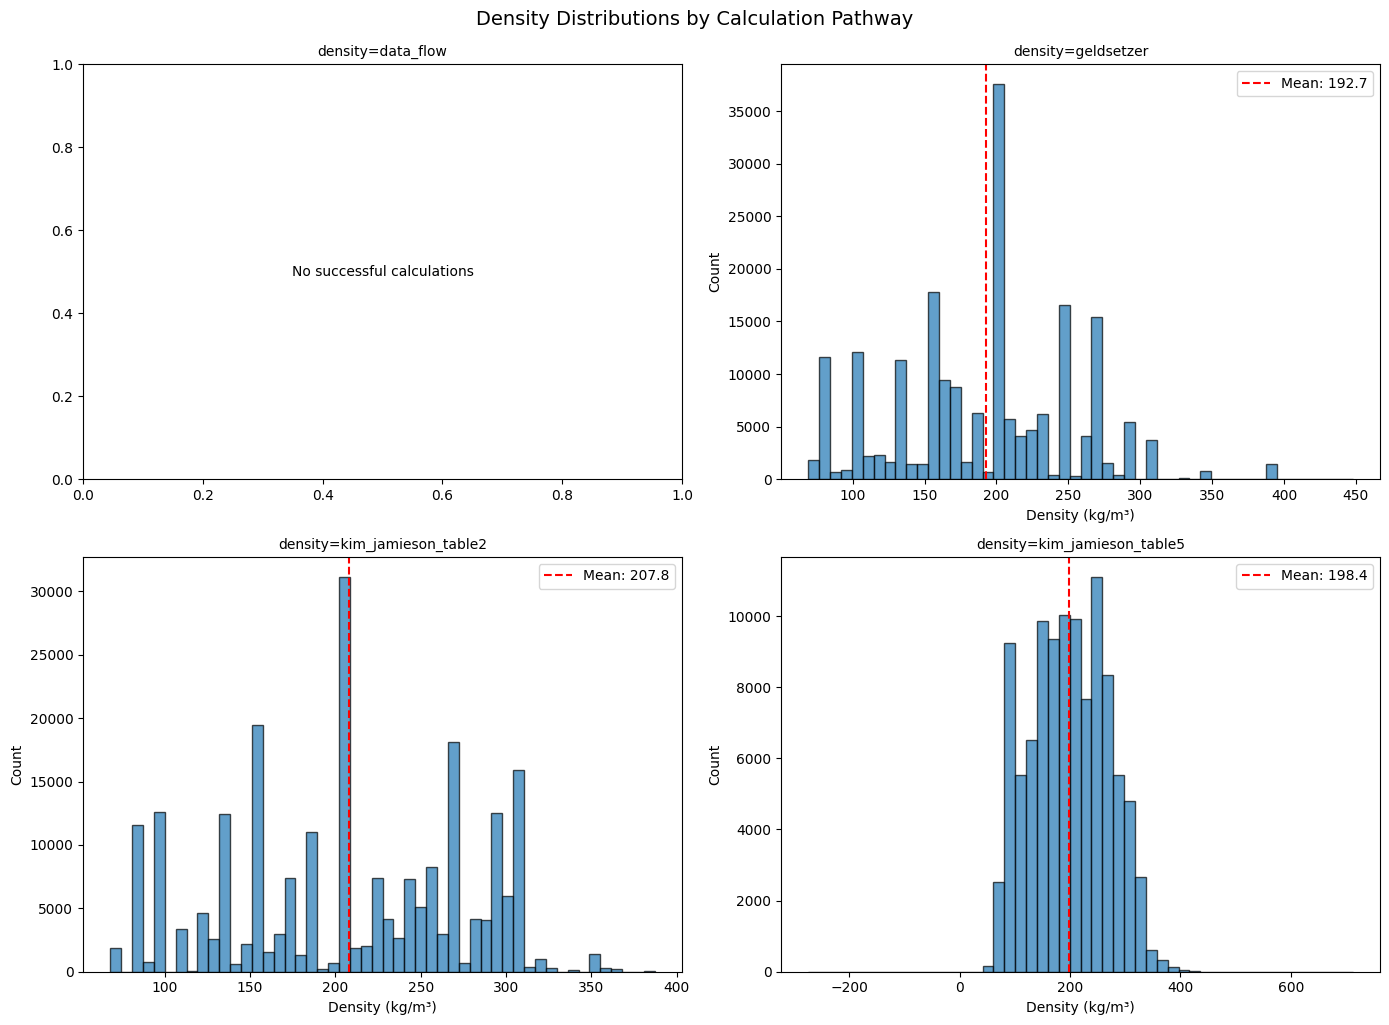

In [8]:
# Create histograms for each pathway
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (pathway_desc, stats) in enumerate(sorted(pathway_stats.items())):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    values = stats['density_values']
    
    if values:
        ax.hist(values, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(values), color='red', linestyle='--', label=f'Mean: {np.mean(values):.1f}')
        ax.set_xlabel('Density (kg/m³)')
        ax.set_ylabel('Count')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No successful calculations', ha='center', va='center', transform=ax.transAxes)
    
    # Shorten title if too long
    title = pathway_desc if len(pathway_desc) < 50 else pathway_desc[:47] + '...'
    ax.set_title(title, fontsize=10)

plt.tight_layout()
plt.suptitle('Density Distributions by Calculation Pathway', y=1.02, fontsize=14)
plt.show()

## 8. Compare Pathways: Measured vs Estimated Density

In [9]:
# Find layers where we have both measured density and estimated density
comparison_data = []

for pit_id, exec_results in all_results.items():
    # Get the data_flow (measured) pathway results
    measured_pathway = None
    estimated_pathways = {}
    
    for pathway_desc, pathway_result in exec_results.results.items():
        if 'data_flow' in pathway_desc.lower():
            measured_pathway = pathway_result
        else:
            estimated_pathways[pathway_desc] = pathway_result
    
    if not measured_pathway:
        continue
    
    # For each layer, compare measured vs estimated
    for layer_idx, measured_layer in enumerate(measured_pathway.slab.layers):
        measured_val = measured_layer.density_measured
        
        if measured_val is None:
            continue
        
        # Get the numeric value
        if hasattr(measured_val, 'nominal_value'):
            measured_density = measured_val.nominal_value
        else:
            measured_density = float(measured_val)
        
        if np.isnan(measured_density):
            continue
        
        # Compare with each estimation method
        for est_pathway_desc, est_pathway_result in estimated_pathways.items():
            if layer_idx >= len(est_pathway_result.slab.layers):
                continue
            
            est_layer = est_pathway_result.slab.layers[layer_idx]
            est_val = est_layer.density_calculated
            
            if est_val is None:
                continue
            
            if hasattr(est_val, 'nominal_value'):
                est_density = est_val.nominal_value
            else:
                est_density = float(est_val)
            
            if np.isnan(est_density):
                continue
            
            comparison_data.append({
                'pit_id': pit_id,
                'layer_idx': layer_idx,
                'pathway': est_pathway_desc,
                'measured': measured_density,
                'estimated': est_density,
                'error': est_density - measured_density,
                'abs_error': abs(est_density - measured_density),
                'pct_error': 100 * (est_density - measured_density) / measured_density
            })

comparison_df = pd.DataFrame(comparison_data)
print(f"Found {len(comparison_df)} layer comparisons between measured and estimated density")

TypeError: float() argument must be a string or a real number, not 'list'

In [ ]:
if not comparison_df.empty:
    # Summary statistics by pathway
    print("\n" + "=" * 80)
    print("ESTIMATION ERROR STATISTICS BY PATHWAY")
    print("=" * 80)
    
    summary = comparison_df.groupby('pathway').agg({
        'error': ['mean', 'std'],
        'abs_error': ['mean', 'median'],
        'pct_error': ['mean', 'std'],
        'measured': 'count'
    }).round(2)
    
    summary.columns = ['Mean Error', 'Std Error', 'MAE', 'Median AE', 'Mean % Error', 'Std % Error', 'N']
    print(summary.to_string())
else:
    print("No comparison data available (no layers with both measured and estimated density)")

In [ ]:
# Scatter plot: measured vs estimated
if not comparison_df.empty:
    pathways_in_data = comparison_df['pathway'].unique()
    n_pathways = len(pathways_in_data)
    
    if n_pathways > 0:
        fig, axes = plt.subplots(1, min(n_pathways, 3), figsize=(5 * min(n_pathways, 3), 5))
        if n_pathways == 1:
            axes = [axes]
        
        for idx, pathway in enumerate(pathways_in_data[:3]):
            ax = axes[idx]
            subset = comparison_df[comparison_df['pathway'] == pathway]
            
            ax.scatter(subset['measured'], subset['estimated'], alpha=0.5, s=10)
            
            # 1:1 line
            lims = [0, max(subset['measured'].max(), subset['estimated'].max()) * 1.1]
            ax.plot(lims, lims, 'r--', label='1:1 line')
            
            ax.set_xlabel('Measured Density (kg/m³)')
            ax.set_ylabel('Estimated Density (kg/m³)')
            ax.set_title(pathway[:40] + '...' if len(pathway) > 40 else pathway, fontsize=9)
            ax.legend()
            ax.set_xlim(lims)
            ax.set_ylim(lims)
        
        plt.tight_layout()
        plt.show()
else:
    print("No comparison data to plot")

## 9. Detailed Results for a Single Slab

In [ ]:
# Pick a slab with multiple layers to examine in detail
sample_pit_id = None
for pid, results in all_results.items():
    # Find a slab with at least 3 layers
    if results.source_slab and len(results.source_slab.layers) >= 3:
        sample_pit_id = pid
        break

if sample_pit_id:
    sample_results = all_results[sample_pit_id]
    print(f"Detailed results for pit: {sample_pit_id}")
    print(f"Number of layers: {len(sample_results.source_slab.layers)}")
    print(f"Number of pathways attempted: {sample_results.total_pathways}")
    print(f"Successful pathways: {sample_results.successful_pathways}")
    print()
    
    # Show results for each pathway
    for pathway_desc, pathway_result in sample_results.results.items():
        print(f"\n{'=' * 60}")
        print(f"Pathway: {pathway_desc}")
        print(f"Success: {pathway_result.success}")
        print(f"Methods: {pathway_result.methods_used}")
        print()
        
        print("Layer results:")
        for layer_idx, layer in enumerate(pathway_result.slab.layers):
            density = layer.density_calculated or layer.density_measured
            
            if density is not None:
                if hasattr(density, 'nominal_value'):
                    density_str = f"{density.nominal_value:.1f} +/- {density.std_dev:.1f}"
                else:
                    density_str = f"{density:.1f}"
            else:
                density_str = "None"
            
            print(f"  Layer {layer_idx}: depth={layer.depth_top}, "
                  f"grain_form={layer.grain_form}, "
                  f"density={density_str}")
else:
    print("No suitable sample slab found")

## 10. Export Results to DataFrame

In [ ]:
# Create a comprehensive results dataframe
export_data = []

for pit_id, exec_results in all_results.items():
    for pathway_desc, pathway_result in exec_results.results.items():
        for layer_idx, layer in enumerate(pathway_result.slab.layers):
            # Get density value and uncertainty
            density_val = layer.density_calculated or layer.density_measured
            if density_val is not None:
                if hasattr(density_val, 'nominal_value'):
                    density_nominal = density_val.nominal_value
                    density_std = density_val.std_dev
                else:
                    density_nominal = float(density_val)
                    density_std = 0.0
            else:
                density_nominal = np.nan
                density_std = np.nan
            
            export_data.append({
                'pit_id': pit_id,
                'pathway': pathway_desc,
                'layer_index': layer_idx,
                'depth_top': layer.depth_top,
                'thickness': layer.thickness,
                'hand_hardness': layer.hand_hardness,
                'grain_form': layer.grain_form,
                'main_grain_form': layer.main_grain_form,
                'grain_size_avg': layer.grain_size_avg,
                'density_measured': layer.density_measured,
                'density_calculated': density_nominal,
                'density_uncertainty': density_std,
                'pathway_success': pathway_result.success
            })

results_df = pd.DataFrame(export_data)
print(f"Created DataFrame with {len(results_df)} rows")
print(f"Columns: {list(results_df.columns)}")
results_df.head(10)

In [ ]:
# Optional: Save to CSV
# Uncomment the following line to save results
# results_df.to_csv('density_results.csv', index=False)
# print("Saved to density_results.csv")

## Summary

This notebook demonstrated:

1. **Loading SnowPilot data** - Parsed XML files into pit objects
2. **Converting to Slabs** - Created Slab/Layer objects with measured properties
3. **Executing all density pathways** - Used the ExecutionEngine to calculate density via all available methods
4. **Analyzing success rates** - Compared which pathways work for which layers based on available data
5. **Comparing methods** - Evaluated estimation accuracy against measured values
6. **Exporting results** - Created a comprehensive DataFrame for further analysis

### Key Observations

- The **data_flow** pathway only succeeds when measured density is available
- Estimation methods (Geldsetzer, Kim-Jamieson) require hand hardness and grain form
- Kim-Jamieson Table 5 additionally requires grain size, so it has lower success rate
- Sub-grain class codes (e.g., 'PPgp', 'FCxr') provide more specific lookup when available